Fabian Brock
Case 7
i6248959
Happy Holidays!

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import pandas as pd

# Option pricing with the Heston Model
Consider the Heston model for equity options with stochastic volatility:
$x_t = ln S_t$,
$dx_t = (r - \frac{1}{2} V_t) dt + \sqrt{V_t} dW_t^S$,
$dV_t = \lambda (\theta - V_t)dt + \sigma_v \sqrt{V_t} dW_t^V$,
$dW_t^S dW_t^V = \rho dt$,
with parameter values:
$r=0.02$, $\theta=(0.1)^2$, $\lambda=2$, , $\sigma_v=0.10$, $\rho=-0.5$, $s_0=ln(100)$, $V_0=(0.1)^2$.

In [86]:
r = 0.02
theta = (0.1)**2
lambda_ = 2 # _ because lambda is a keyword :(
sigma_V = 0.10
rho = -0.5
S0 = np.log(100)
V0 = (0.1)**2
T = 10  # maturity in years

# Monte Carlo simulation parameters
N = 100 # number of time steps (daily steps for 10 years)
dt = T / N  # time step
M = 100000  # number of simulated paths
K = 10  # strike price (example)
np.random.seed(42)  

In [87]:
def heston_call_option_price(K, N, M, r=0.02, theta=(0.1)**2, lambda_=2, sigma_V=0.10, rho=-0.5, S0=np.log(100), V0=(0.1)**2, T=10):
    dt = T / N
    
    S_paths = np.zeros((M, N + 1))
    V_paths = np.zeros((M, N + 1))
    
    S_paths[:, 0] = S0
    V_paths[:, 0] = V0

    # paths
    for i in range(1, N + 1):
        Z_S = np.random.normal(size=M)
        Z_V = rho * Z_S + np.sqrt(1 - rho**2) * np.random.normal(size=M)


        V_paths[:, i] = V_paths[:, i - 1] + lambda_ * (theta - V_paths[:, i - 1]) * dt + sigma_V * np.sqrt(np.maximum(V_paths[:, i - 1], 0)) * np.sqrt(dt) * Z_V
        
        S_paths[:, i] = S_paths[:, i - 1] + (r - 0.5 * V_paths[:, i - 1]) * dt + np.sqrt(np.maximum(V_paths[:, i - 1], 0)) * np.sqrt(dt) * Z_S

    # call payoff
    payoffs = np.maximum(np.exp(S_paths[:, -1]) - K, 0)

    # avg discounted payoff
    option_price = np.exp(-r * T) * np.mean(payoffs)
    # stderr
    stderr = np.std(np.exp(-r * T) * payoffs) / np.sqrt(M)
    
    return option_price, stderr

In [88]:
# test for K=100
price, stderr = heston_call_option_price(100, N=10, M=100000)
print(f"Price: {price:.4f} with SE: {stderr:.4f}")


Price: 26.9694 with SE: 0.1245


In [89]:
# compute prices for strikes from 50 - 200 in steps of 10
strikes = np.arange(50, 210, 10)
prices = np.zeros_like(strikes, dtype=float)
stderrs = np.zeros_like(strikes, dtype=float)

for i, K in enumerate(strikes):
    prices[i], _ = heston_call_option_price(K, N, M)
    _, stderrs[i] = heston_call_option_price(K, N, M)
    

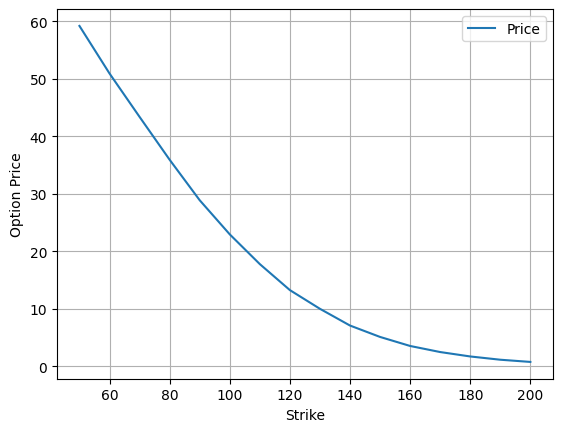

In [90]:
# plot prices and stderrs
plt.plot(strikes, prices, label="Price")
plt.xlabel("Strike")
plt.ylabel("Option Price")
plt.grid(True)
plt.legend()
plt.show()


In [91]:
import scipy.stats as sps
import scipy.optimize as spo
import matplotlib.pyplot as plt

# Black-Scholes formula for a call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * sps.norm.cdf(d1) - K * np.exp(-r * T) * sps.norm.cdf(d2)
    return call_price

# Function to calculate implied volatility
def implied_volatility(Heston_price, S, K, T, r):
    def f(sigma):
        return black_scholes_call(S, K, T, r, sigma) - Heston_price
    iv = spo.brentq(f, -1, 2)
    return iv

In [92]:
IVs = []
for K in strikes:
    price, _ = heston_call_option_price(K, N, M)
    IVs.append(implied_volatility(price, np.exp(S0), K, T, r))

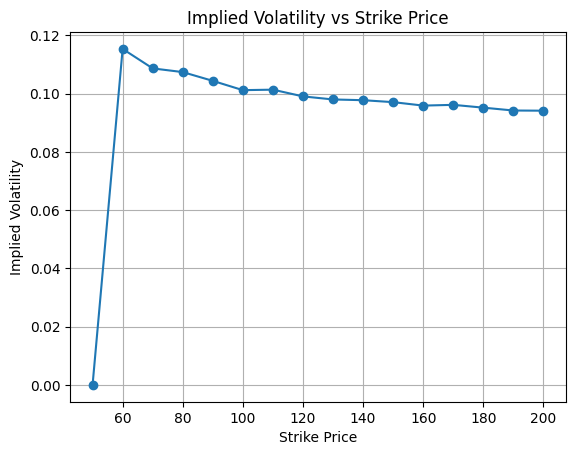

In [93]:
plt.plot(strikes, IVs, marker="o")
plt.title("Implied Volatility vs Strike Price")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()


## Fourier transform
$e^{-rT} e^{-ax}max\{e^x - K, 0\}$,

After splitting the ft integral (nonzero for x>=ln(K)) and simplifying:

$e^{-rt} \int_{ln(K)}^{\infty} e^{(1-a-ik)x} - Ke^{(-a-ik)x} dx$,

From this a must be strictly greater than 1


In [94]:
r = 0.02
q = 0 # dividend yield
s = 100.0 # not log here
V0 = 0.01 
lambda_ = 2 
theta = 0.1 ** 2
sigma_V = 0.1
rho = -0.5
k = 100
T = 10


In [95]:
# used this for help: 
# https://www.scribd.com/document/486716159/The-vol-smile-problem-FX-focus
# the vol smile problem, Lipton 2002, Risk

def phi(u, T):
    alpha_hat = -0.5 * u * (u + 1j)
    beta = lambda_ - 1j * u * sigma_V * rho
    gamma = 0.5 * sigma_V ** 2
    d = np.sqrt(beta**2 - 4 * alpha_hat * gamma)
    g = (beta - d) / (beta + d)
    h = np.exp(-d*T)
    A_ = (beta-d)*T - 2*np.log((g*h-1) / (g-1))
    A = lambda_ * theta / (sigma_V**2) * A_
    B = (beta - d) / (sigma_V**2) * (1 - h) / (1 - g*h)
    return np.exp(A + B * V0)

def integral(k, T):
    integrand = (lambda u: 
        np.real(np.exp((1j*u + 0.5)*k)*phi(u - 0.5j, T))/(u**2 + 0.25))

    i, err = scipy.integrate.quad(integrand, 0, np.inf)
    return i

def call(k, T):
    a = np.log(s/k) + (r-q)*T
    i = integral(a, T)        
    return s * np.exp(-q*T) - k * np.exp(-r*T)/np.pi*i
    
print("Price with K=100:",call(k, T))

Price with K=100: 22.806991845424662


In [96]:
# get prices for strikes 50-200
fi_prices = np.zeros_like(strikes, dtype=float)

for i, K in enumerate(strikes):
    fi_prices[i] = call(K, T)

allprices = np.vstack((strikes, prices, fi_prices, stderrs)).T

## Comparison

In [97]:
df = pd.DataFrame(allprices, columns=["Strike", "Fourier", "MC", "Stderr"])
df["Diff"] = abs(df["Fourier"] - df["MC"])
df

,Strike,Fourier,MC,Stderr,Diff
0,50.0,59.165888,59.099941,0.099878,0.065947
1,60.0,50.896525,51.036393,0.099202,0.139868
2,70.0,43.347610,43.192182,0.097717,0.155428
3,80.0,35.894034,35.746748,0.093810,0.147285
4,90.0,28.854012,28.895943,0.089442,0.041930
5,100.0,22.918693,22.806992,0.083910,0.111701
6,110.0,17.745168,17.584596,0.076318,0.160572
7,120.0,13.224282,13.258239,0.068253,0.033956
8,130.0,9.971562,9.789278,0.059762,0.182284
9,140.0,7.060973,7.089952,0.051024,0.028979
